In [4]:
# --- System Check and Environment Diagnostics ---

import sys, os, platform, duckdb, pandas as pd

print("🧩 Environment Diagnostics")
print("--------------------------")
print(f"Python executable: {sys.executable}")
print(f"Python version: {platform.python_version()}")
print(f"Working directory: {os.getcwd()}")
print(f"DuckDB version: {duckdb.__version__}")
print(f"Pandas version: {pd.__version__}")

# Check critical files
print("\nProject files:")
for f in [".env", "requirements.txt", "src/config.py"]:
    print(f"  {'✅' if os.path.exists(f) else '❌'} {f}")

print("\n✅ Environment looks good — ready to proceed.")



🧩 Environment Diagnostics
--------------------------
Python executable: C:\Users\ITSMARTSOLUTIONS\Documents\Python Scripts\energy-market-intelligence-platform\.venv\Scripts\python.exe
Python version: 3.11.9
Working directory: C:\Users\ITSMARTSOLUTIONS\Documents\Python Scripts\energy-market-intelligence-platform
DuckDB version: 1.4.1
Pandas version: 2.3.3

Project files:
  ✅ .env
  ✅ requirements.txt
  ✅ src/config.py

✅ Environment looks good — ready to proceed.


In [6]:
from pathlib import Path

# Create the folder if it doesn't exist
Path("data/raw").mkdir(parents=True, exist_ok=True)
print("✅ Folder structure ready at:", Path("data/raw").resolve())


✅ Folder structure ready at: C:\Users\ITSMARTSOLUTIONS\Documents\Python Scripts\energy-market-intelligence-platform\data\raw


In [7]:
# --- Setup & Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path

DATA_DIR = Path("data/raw")


In [9]:
# --- Load and Clean Flow-Based Congestion Income Data ---
file_path = DATA_DIR / "flowbased_congestion_income_R3_day_ahead_latest.xlsx"

# Load the sheet, skip metadata rows
df = pd.read_excel(file_path, sheet_name="1", skiprows=5)

# Clean column names
df.columns = ["TimeInterval", "RevenueEUR"]

# Drop any missing or non-numeric values
df = df.dropna(subset=["TimeInterval", "RevenueEUR"])
df["RevenueEUR"] = pd.to_numeric(df["RevenueEUR"], errors="coerce")

print("✅ Cleaned data shape:", df.shape)
df.head()


✅ Cleaned data shape: (98, 2)


,TimeInterval,RevenueEUR
0,12/11/2025 00:00 - 13/11/2025 00:00,NaN
1,MTU,NaN
2,12/11/2025 00:00 - 12/11/2025 00:15,3819.97
3,12/11/2025 00:15 - 12/11/2025 00:30,3793.45
4,12/11/2025 00:30 - 12/11/2025 00:45,3763.63


In [10]:
# --- Parse Time Intervals and Clean Data Further ---
import numpy as np

# Remove rows like 'MTU' or daily summary lines (which contain ' - ' but no numeric revenue)
df = df[df['RevenueEUR'].notna()]
df = df[~df['TimeInterval'].str.contains("MTU", na=False)]

# Split the "TimeInterval" column into start and end timestamps
df[['Start', 'End']] = df['TimeInterval'].str.split(' - ', expand=True)

# Parse timestamps (handles CET/CEST automatically as strings)
df['Start'] = pd.to_datetime(df['Start'], errors='coerce', dayfirst=True)
df['End'] = pd.to_datetime(df['End'], errors='coerce', dayfirst=True)

# Use start time as index for time series
df = df.set_index('Start').sort_index()

# Drop redundant columns
df = df[['RevenueEUR']]

print("✅ Parsed time intervals. Data shape:", df.shape)
df.head()


✅ Parsed time intervals. Data shape: (96, 1)


,RevenueEUR
Start,
2025-11-12 00:00:00,3819.97
2025-11-12 00:15:00,3793.45
2025-11-12 00:30:00,3763.63
2025-11-12 00:45:00,2966.23
2025-11-12 01:00:00,4005.20


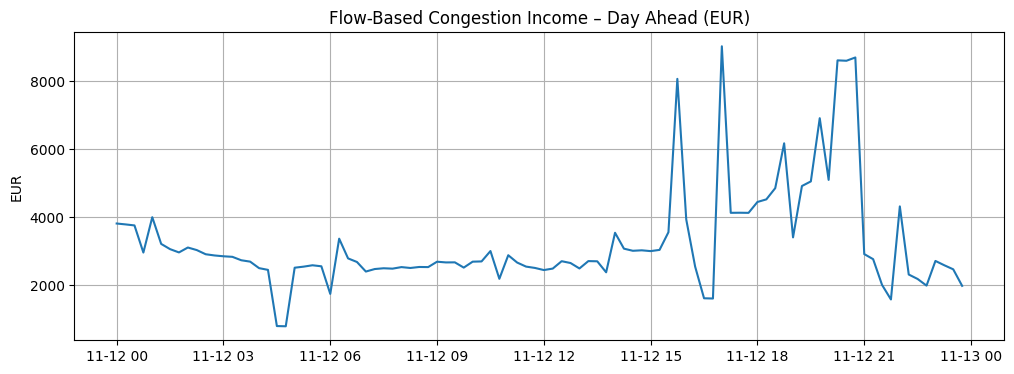

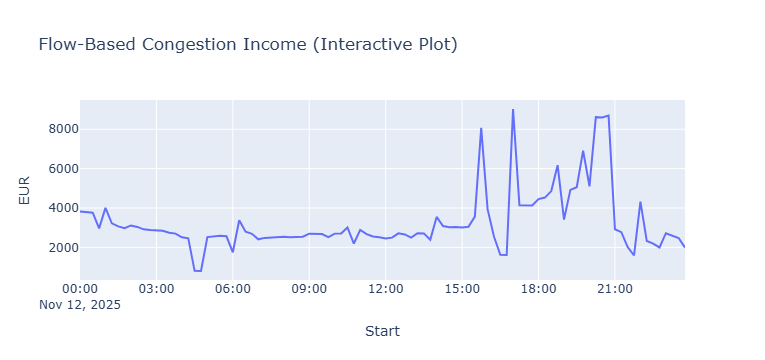

In [11]:
# --- Visualize congestion income over time ---
import matplotlib.pyplot as plt
import plotly.express as px

plt.figure(figsize=(12,4))
plt.plot(df.index, df['RevenueEUR'])
plt.title("Flow-Based Congestion Income – Day Ahead (EUR)")
plt.ylabel("EUR")
plt.grid(True)
plt.show()

fig = px.line(df, x=df.index, y='RevenueEUR',
              title="Flow-Based Congestion Income (Interactive Plot)",
              labels={'x':'Time', 'RevenueEUR':'EUR'})
fig.show()


In [13]:
# --- Save cleaned dataset for later analysis ---
processed_path = Path("data/processed/flowbased_congestion_income_clean.parquet")
df.to_parquet(processed_path)
print(f"✅ Saved processed dataset to {processed_path}")


✅ Saved processed dataset to data\processed\flowbased_congestion_income_clean.parquet


In [14]:
# --- Summary Report ---
print("Date range:", df.index.min(), "→", df.index.max())
print("Mean revenue:", round(df.RevenueEUR.mean(), 2), "EUR")
print("Volatility (std):", round(df.RevenueEUR.std(), 2), "EUR")
print("Max / Min:", round(df.RevenueEUR.max(), 2), "/", round(df.RevenueEUR.min(), 2), "EUR")

# Optional: simple hourly resampling summary
df_hourly = df.resample("H").mean()
print(f"\nHourly average revenue range: {df_hourly.RevenueEUR.min():.2f} – {df_hourly.RevenueEUR.max():.2f} EUR")

# Optional: correlation / variability hints
print(f"Coefficient of variation: {df.RevenueEUR.std() / df.RevenueEUR.mean():.2%}")


Date range: 2025-11-12 00:00:00 → 2025-11-12 23:45:00
Mean revenue: 3263.84 EUR
Volatility (std): 1576.11 EUR
Max / Min: 9029.59 / 799.09 EUR

Hourly average revenue range: 1642.45 – 7755.64 EUR
Coefficient of variation: 48.29%


C:\Users\ITSMARTSOLUTIONS\AppData\Local\Temp\ipykernel_20032\322118063.py:8: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



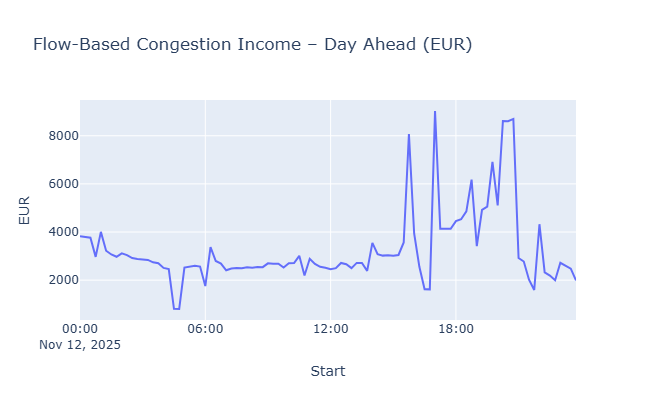

### 🤖 LLM Market Analysis

Based on the provided congestion income data summary for the DK2 bidding zone, here's an analysis of the key metrics:

**Volatility:**
The coefficient of variation (48.29%) indicates that there is significant volatility in the mean revenue over the observed period. This high level of variability suggests that market conditions are unpredictable and subject to rapid changes.

**Market Behavior:**
The mean revenue of €3,263.84 and maximum revenue of €9,029.59 imply that market participants have been able to capture substantial congestion income opportunities during this period. The low minimum revenue of €799.09 indicates that there may be instances where the market is not well-balanced or there are limited transmission constraints.

**Potential Grid or Interconnection Conditions:**
The high maximum revenue and significant volatility suggest that DK2's grid or interconnections with neighboring zones are experiencing periods of congestion, particularly during peak demand hours. This might be due to:

1. **Transmission bottlenecks**: Insufficient transmission capacity between DK2 and other bidding zones could be limiting the flow of power and creating congestion.
2. **Interconnection constraints**: The presence of congested interconnectors may force market participants to adapt their bids, leading to volatile revenue streams.
3. **Load balancing challenges**: Imbalances in demand and supply within DK2 or across neighboring zones might require additional transmission capacity or flexible resources.

**Recommendations:**
To better understand the underlying factors driving these trends, further analysis could focus on:

1. Investigating the timing of peak revenues to identify specific periods of congestion.
2. Examining the relationship between revenue volatility and transmission constraints.
3. Analyzing the impact of nearby generation and load patterns on congestion income.

These insights can inform grid operators, system planners, and market participants about potential bottlenecks in the DK2 zone's grid or interconnections, enabling more effective management of congestion and capacity allocation.

In [15]:
# --- AI-Assisted Market Summary Report (Enhanced) ---
import json, textwrap, requests, os
from dotenv import load_dotenv
import plotly.express as px
from IPython.display import display, Markdown

load_dotenv()

# Local LLM configuration
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://localhost:11434")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL", "llama3.1:8b-instruct-q8_0")

# --- Compute summary metrics ---
summary_data = {
    "Date range": f"{df.index.min()} → {df.index.max()}",
    "Mean revenue (EUR)": round(df.RevenueEUR.mean(), 2),
    "Volatility (std EUR)": round(df.RevenueEUR.std(), 2),
    "Max revenue (EUR)": round(df.RevenueEUR.max(), 2),
    "Min revenue (EUR)": round(df.RevenueEUR.min(), 2),
    "Coefficient of variation": f"{(df.RevenueEUR.std() / df.RevenueEUR.mean())*100:.2f} %",
}

# --- Visualization ---
fig = px.line(
    df,
    x=df.index,
    y="RevenueEUR",
    title="Flow-Based Congestion Income – Day Ahead (EUR)",
    labels={"x": "Time (CET)", "RevenueEUR": "EUR"},
)
fig.update_layout(height=400)
fig.show()

# --- Construct prompt for LLM ---
prompt = f"""
You are an experienced energy market analyst. 
Interpret the following congestion income data summary and trend chart for the DK2 bidding zone.

Dataset summary:
{json.dumps(summary_data, indent=2)}

Explain what these metrics imply about volatility, market behavior, 
and potential grid or interconnection conditions. 
Keep the tone factual, concise, and analytical.
"""

# --- Query local LLM via Ollama ---
try:
    payload = {"model": OLLAMA_MODEL, "prompt": prompt, "stream": False}
    response = requests.post(f"{OLLAMA_URL}/api/generate", json=payload)
    analysis_text = response.json().get("response", "").strip()

    if analysis_text:
        display(Markdown(f"### 🤖 LLM Market Analysis\n\n{analysis_text}"))
    else:
        print("⚠️ No response from local LLM. Check model name or Ollama service.")
except Exception as e:
    print("⚠️ Error connecting to local LLM:", e)


In [18]:
# --- Export Interactive Report as HTML (Improved Formatting) ---
from datetime import datetime
from pathlib import Path
import plotly.io as pio
import markdown

# Ensure reports directory exists
REPORTS_DIR = Path("reports")
REPORTS_DIR.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
report_path = REPORTS_DIR / f"congestion_income_analysis_{timestamp}.html"

# Convert LLM markdown to HTML (preserve bold, lists, headings)
analysis_html = markdown.markdown(
    analysis_text,
    extensions=["extra", "sane_lists"]
)

# Build header and figure
html_header = f"""
<h2>Flow-Based Congestion Income Report</h2>
<p><strong>Generated:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M')}</p>
<p><strong>Model:</strong> {OLLAMA_MODEL}</p>
"""

fig_html = pio.to_html(fig, full_html=False, include_plotlyjs="cdn")

# Assemble full report with improved CSS
html_content = f"""
<html>
<head>
<meta charset="UTF-8">
<title>Congestion Income Report</title>
<style>
  body {{
    font-family: "Segoe UI", Arial, sans-serif;
    margin: 40px;
    color: #222;
    line-height: 1.6;
    background-color: #fdfdfd;
  }}
  h2 {{
    color: #2a3f5f;
    margin-bottom: 10px;
  }}
  h3 {{
    color: #3b5998;
    margin-top: 25px;
    border-bottom: 2px solid #e0e0e0;
    padding-bottom: 5px;
  }}
  .analysis {{
    margin-top: 25px;
    padding: 20px;
    background-color: #f8f9fb;
    border-radius: 8px;
    border: 1px solid #e0e0e0;
  }}
  p {{
    margin-bottom: 10px;
  }}
  ul {{
    margin-left: 20px;
  }}
  li {{
    margin-bottom: 6px;
  }}
  strong {{
    color: #1b3556;
  }}
</style>
</head>
<body>
{html_header}
{fig_html}
<div class="analysis">
<h3>🤖 LLM Market Analysis</h3>
{analysis_html}
</div>
</body>
</html>
"""

# Save file
with open(report_path, "w", encoding="utf-8") as f:
    f.write(html_content)

print(f"✅ Improved report saved to: {report_path.resolve()}")


✅ Improved report saved to: C:\Users\ITSMARTSOLUTIONS\Documents\Python Scripts\energy-market-intelligence-platform\reports\congestion_income_analysis_20251112_0333.html


## 📊 What This Notebook Accomplishes

This notebook establishes the **foundation for Phase 1 – Data Ingestion & Cleaning** in the  
_“Open Power Analyst: Energy Market Intelligence Platform”_ project.

### ✅ Key Achievements

- **Direct data integration from ENTSO-E sources**  
  Loads real transparency data (CSV or Excel) for flow-based congestion income, prices, and related metrics (later API).  

- **Data cleaning and timestamp alignment**  
  Parses complex “start–end” intervals into proper datetime indices, removes metadata rows, and ensures 15-minute resolution consistency.

- **Exploratory visualization**  
  Generates both static (Matplotlib) and interactive (Plotly) charts to reveal intraday revenue dynamics and volatility patterns.

- **Summary statistics**  
  Computes descriptive analytics such as mean revenue, standard deviation, and coefficient of variation for quick diagnostic insight.

- **AI-assisted interpretation (local LLM)**  
  Uses a local model (e.g., `llama3.1:8b-instruct-q8_0`) to automatically produce concise written analysis contextualizing market behavior.

- **Automated reporting pipeline**  
  Exports a standalone HTML report combining visuals, key metrics, and LLM commentary — ready for sharing or archival.

- **Clean data export for forecasting**  
  Saves a structured, analysis-ready parquet file (`data/processed/…`) for Phase 2 feature engineering and predictive modeling.

---

### 🔁 Next Step

Proceed to **`2_preprocessing.ipynb`** to:
- build lag and rolling features,
- engineer temporal attributes (hour, day-of-week, etc.), and
- prepare the dataset for machine-learning forecasting pipelines.
